Исследование статистики задержек авиарейсов

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler


Загружаем данные и удаляем строки с пропущенными значениями

In [5]:
raw_df = pd.read_csv("flights_NY.csv")
raw_df.dropna(axis=0, inplace=True)
raw_df

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336765,2013,9,30,2240.0,-5.0,2334.0,-17.0,B6,N354JB,1816,JFK,SYR,41.0,209
336766,2013,9,30,2240.0,-10.0,2347.0,-20.0,B6,N281JB,2002,JFK,BUF,52.0,301
336767,2013,9,30,2241.0,-5.0,2345.0,-16.0,B6,N346JB,486,JFK,ROC,47.0,264
336768,2013,9,30,2307.0,12.0,2359.0,1.0,B6,N565JB,718,JFK,BOS,33.0,187


Задание 1. По каждой авиакомпании оцените вероятность того, что задержка прилета будет положительной и нарисуйте график, показывающий распределение этой вероятности по авиакомпаниям.


Оценим вероятность задержки прибытия для каждой авиакомпании как долю задерженных рейсов среди всех рейсов

In [179]:
carriers = raw_df.carrier.unique()
arr_delay_freq = {x : raw_df.loc[(raw_df.arr_delay>0)&(raw_df.carrier==x), 'arr_delay'].count()/
                                 raw_df.loc[(raw_df.carrier==x), 'arr_delay'].count() 
                                 for x in carriers }
arr_delay_freq

{'UA': 0.38458343428749436,
 'AA': 0.3351175384230131,
 'B6': 0.43680734148642897,
 'DL': 0.34439128792647616,
 'EV': 0.4790639430226188,
 'MQ': 0.4670287973798778,
 'US': 0.3705814129393374,
 'WN': 0.44038525406841583,
 'VX': 0.34128225175918686,
 'FL': 0.5968503937007874,
 'AS': 0.26657263751763044,
 '9E': 0.38377471955591536,
 'F9': 0.5756240822320118,
 'HA': 0.28362573099415206,
 'YV': 0.4742647058823529,
 'OO': 0.3448275862068966}

In [189]:
min(arr_delay_freq.values())

0.26657263751763044

In [190]:
max(arr_delay_freq.values())

0.5968503937007874

Построим график распределения вероятности задержки по авиакомпаниям

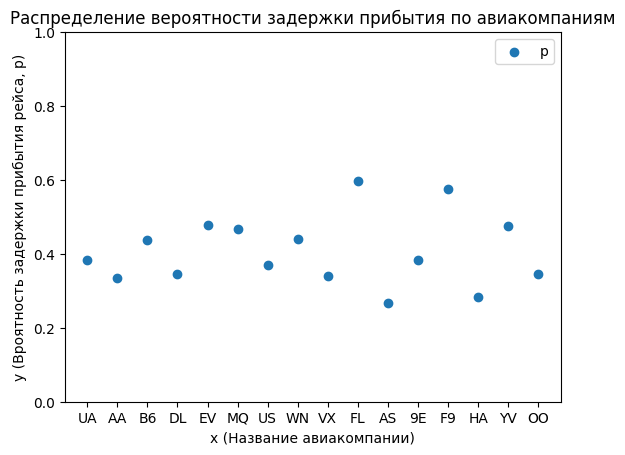

In [285]:
plt.scatter(arr_delay_freq.keys(), arr_delay_freq.values())
ax = plt.gca()
ax.set_ylim([0, 1])
plt.title('Распределение вероятности задержки прибытия по авиакомпаниям')
plt.xlabel('x (Название авиакомпании)')
plt.ylabel('y (Вроятность задержки прибытия рейса, p)')
plt.legend('p')
plt.show()


Делаем вывод: авиакомпания с самым болшим процентом задержек - это FL с вероятностью задержки прибытия 59,7%,
авиакомпания с самым маленьким процентом задержек - это AS с вероятностью задержки прибытия 26,7%.

Задание 2. Постройте гистограмму расстояния перелета distance. Выделите на ней три группы перелетов: короткие, средние и длинные. Какие значения distance разумно выбрать в качестве границы, разделяющей короткие. средние и длинные перелеты? Куда летят самолеты в группе длинных перелетов? Найдите среднее время задержки вылета в каждой из трех выделенных групп. 

Число бинов определено по правилу Freedman-Diaconis. 
Для определения "коротких", "средних" и "длинных" перелетов исходя только из данных в таблице можно использовать квантили, чтобы оценить длину относительно всех доступных примеров. Делим весь диапазон на 3 части квантилями   0.2 и 0.8, т.к. длина понятие относительное и, наверное, логично выделить в "средние" перелеты наибольшую группу, как самые часто встречающиеся.

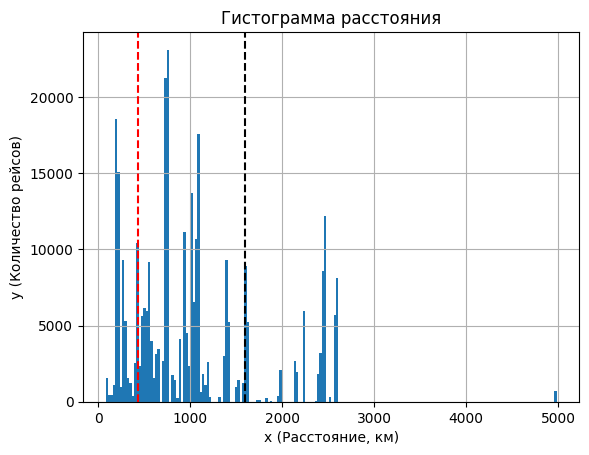

In [257]:
short = raw_df.distance.quantile(0.2)
average = raw_df.distance.quantile(0.8)
raw_df.hist(column='distance', bins='auto')
plt.title('Гистограмма расстояния')
plt.xlabel('x (Расстояние, км)')
plt.ylabel('y (Количество рейсов)')
plt.axvline(x=short, color='r', linestyle='--', label='Короткие перелеты')
plt.axvline(x=average, color='black', linestyle='--', label='Средние перелеты')

Можно также использовать метод k-средних.

In [196]:
distances = raw_df['distance'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(distances)
raw_df['distance_cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_.flatten()
cluster_centers.sort()
short_flight_max = cluster_centers[0]
medium_flight_max = cluster_centers[1]

print(f"Короткие до {short_flight_max} миль, средние от {short_flight_max} миль до {medium_flight_max} миль, длинные - больше {medium_flight_max} миль.")


Короткие до 484.03613198225116 миль, средние от 484.03613198225116 миль до 1173.251675041831 миль, длинные - больше 1173.251675041831 миль.


Найдем пункты назначения длинных перелетов.

In [199]:
raw_df.loc[raw_df.distance>average]['dest'].value_counts()


dest
LAX    16026
SFO    13173
DEN     7169
LAS     5952
PHX     4606
SEA     3885
SAN     2709
SLC     2451
PDX     1342
SJU     1063
SNA      812
HNL      701
LGB      661
STT      518
BUR      370
PSE      358
SJC      328
OAK      309
SMF      282
ABQ      254
EGE      207
BZN       35
JAC       21
PSP       18
HDN       14
MTJ       14
ANC        8
Name: count, dtype: int64

Вывод: большинство рейсов направляются в аэропорт LAX.

Добавим новую колонку с информацией об относительной длине перелета. Сгруппируем рейсы по категории длины перелета и для каждой категории найдем среднее время задержки вылета.

Среднее время задержки вылета по категориям длины:
flight_length
average    12.832631
long       11.112932
short      13.094648
Name: dep_delay, dtype: float64


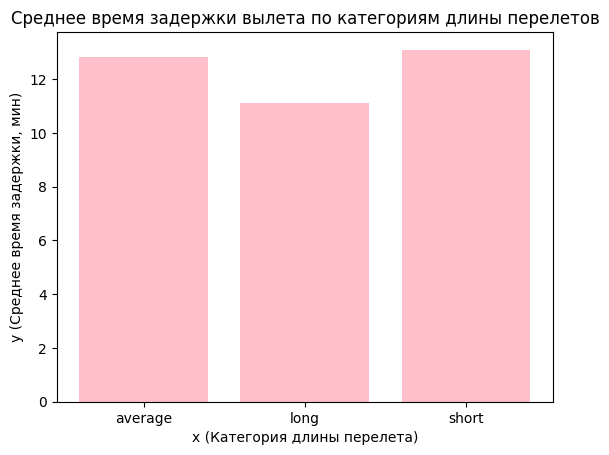

In [256]:
# Анализ пунктов назначения для длинных перелетов
raw_df.loc[raw_df.distance<=short, 'flight_length'] = 'short'
raw_df.loc[(short<raw_df.distance)&(raw_df.distance<=average), 'flight_length'] = 'average'
raw_df.loc[raw_df.distance>average, 'flight_length'] = 'long'

average_delay_by_category = raw_df.groupby('flight_length')['dep_delay'].mean()
print("Среднее время задержки вылета по категориям длины:")
print(average_delay_by_category)

plt.figure()
plt.bar(x=average_delay_by_category.index, height=average_delay_by_category.values, color='pink')
plt.title('Среднее время задержки вылета по категориям длины перелетов')
plt.xlabel('x (Категория длины перелета)')
plt.ylabel('y (Среднее время задержки, мин)')
plt.show()

Меньше всего задерживаются длинные перелеты, но разница несущественная, наверное, от длины перелета сильной зависимости нет.

Задание 3. Нарисуйте график среднего времени задержки вылета по месяцам и отметьте на нем границы доверительных интервалов с уровнем доверия 0.95. С помощью подходящего статистического теста проверьте, можно ли принять гипотезу о равенстве средних в январе и феврале на уровне значимости 0.05? на уровне значимости 0.01?

Вычислим средние, дисперсии и общее количество рейсов по месяцам. Найдем границы доверительных интервалов с уровнем доверия 0.95.

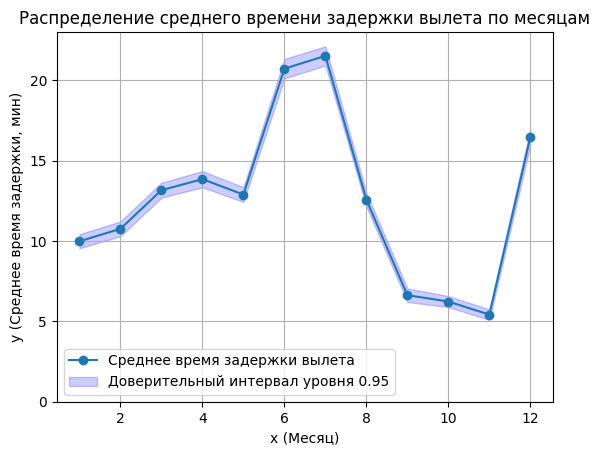

In [255]:
monthly_means = raw_df.groupby('month')['dep_delay'].mean()
monthly_stds = raw_df.groupby('month')['dep_delay'].std()
monthly_counts = raw_df.groupby('month')['dep_delay'].count()

conf_lvl = 0.95
z = stats.norm.ppf(1 - (1 - conf_lvl) / 2)
conf_upper = monthly_means + z * (monthly_stds / np.sqrt(monthly_counts))
conf_lower = monthly_means - z * (monthly_stds / np.sqrt(monthly_counts))
plt.figure()
ax = plt.gca()
ax.set_ylim([0, 23])
plt.plot(monthly_means.index, monthly_means, marker='o', label='Среднее время задержки вылета')
plt.fill_between(monthly_means.index, conf_lower, conf_upper, color='b', alpha=0.2, label='Доверительный интервал уровня 0.95')
plt.xlabel('x (Месяц)')
plt.ylabel('y (Среднее время задержки, мин)')
plt.title('Распределение среднего времени задержки вылета по месяцам')
plt.legend()
plt.grid()
plt.show()


График показывает в каком диапазоне с вероятностью 95% находится истинное среднее значение задержки вылета для каждого месяца в 2013 году.

Чтобы выбрать статистический тест проверим нормальность распределений для января и февраля по тесту Шапиро-Уилка, и проверим равенства дисперсий по Levene.

С помощью выбранного статистического теста определим можно ли принять гипотезу о равенстве средних в январе и феврале.
Нулевая гипотеза $H_0$: Средние задержки в январе и феврале равны.
Альтернативная гипотеза $H_1$: Средние задержки в январе и феврале не равны.

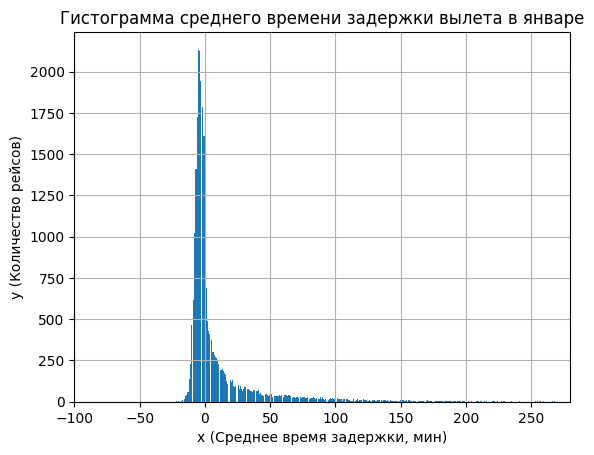

In [254]:
january_delays = raw_df[raw_df['month'] == 1]['dep_delay']
february_delays = raw_df[raw_df['month'] == 2]['dep_delay']

ax = plt.gca()
ax.set_xlim([-100, 280])
january_delays.hist(bins='auto')
plt.title('Гистограмма среднего времени задержки вылета в январе')
plt.xlabel('x (Среднее время задержки, мин)')
plt.ylabel('y (Количество рейсов)')
plt.show()

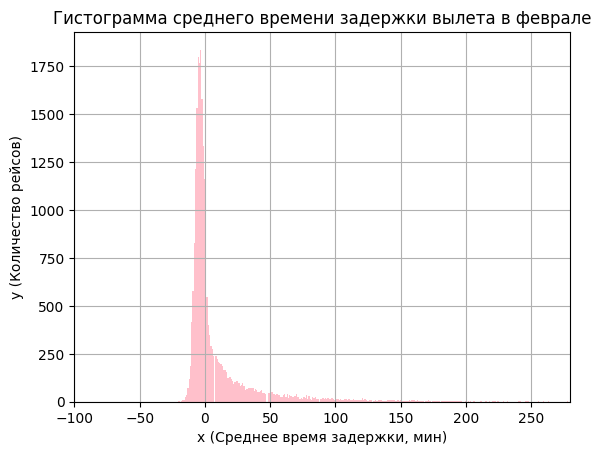

In [253]:
# plt.figure()
ax = plt.gca()
ax.set_xlim([-100, 280])
february_delays.hist(bins='auto', color='pink')
plt.title('Гистограмма среднего времени задержки вылета в феврале')
plt.xlabel('x (Среднее время задержки, мин)')
plt.ylabel('y (Количество рейсов)')
plt.show()

Полагаем, что статистики за январь и февраль имеют нормальное распределение и одинаковую дисперсию, тогда можно применить t-тест Стьюдента.

In [153]:
january_delays = raw_df[raw_df['month'] == 1]['dep_delay']
february_delays = raw_df[raw_df['month'] == 2]['dep_delay']

t_stat, p_value = stats.ttest_ind(january_delays, february_delays)

print(f't-статистика: {t_stat}, p-значение: {p_value}')

alpha_05 = 0.05
alpha_01 = 0.01

if p_value < alpha_05:
    print("На уровне значимости 0.05, мы отвергаем нулевую гипотезу.")
else:
    print("На уровне значимости 0.05, мы не можем отвергнуть нулевую гипотезу.")

if p_value < alpha_01:
    print("На уровне значимости 0.01, мы отвергаем нулевую гипотезу.")
else:
    print("На уровне значимости 0.01, мы не можем отвергнуть нулевую гипотезу.")


t-статистика: -2.386498623322741, p-значение: 0.017013366495100532
На уровне значимости 0.05, мы отвергаем нулевую гипотезу.
На уровне значимости 0.01, мы не можем отвергнуть нулевую гипотезу.


In [289]:
anderson_january = stats.anderson(january_delays, 'norm')
anderson_february = stats.anderson(february_delays, 'norm')
levene_test = stats.levene(january_delays, february_delays)
print(f'Anderson-Darling тест для января: {anderson_january}')
print(f'Anderson-Darling тест для февраля: {anderson_february}')
print(f'Levene тест для равенства дисперсий: {levene_test}')


Anderson-Darling тест для января: AndersonResult(statistic=4164.715048826329, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=9.985491325100387, scale=36.30906081448395)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson-Darling тест для февраля: AndersonResult(statistic=3529.483087791308, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=10.760238871712337, scale=36.1678470495144)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Levene тест для равенства дисперсий: LeveneResult(statistic=4.683302598420938, pvalue=0.03046185831685606)


Задание 4. Найдите коэффициент корреляции между расстоянием distance и временем полета air_time. Постройте точечную диаграмму в осях distance (х) и air_time (y). Найдите коэффициенты линейной регрессии и нанесите полученную прямую на график. Как можно интерпретировать смысл коэффициентов полученной линейной модели?

Найдем коэффициент корреляции Пирсона между значениями дистанции и время полета. Аппроксимируем зависимость на точечной диаграмме прямой с помощью линейной регрессии.

Коэффициент корреляции между расстоянием и временем полета: 0.99


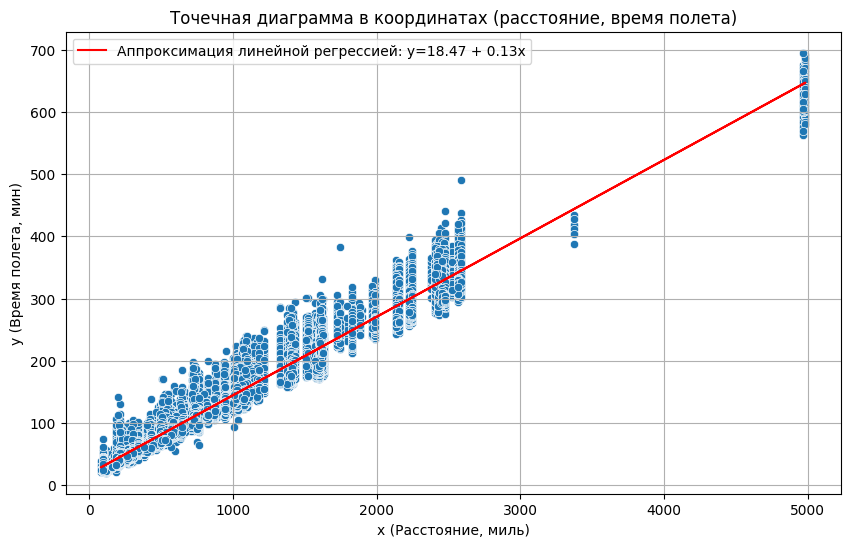

In [259]:
correlation = raw_df['distance'].corr(raw_df['air_time'])
print(f"Коэффициент корреляции между расстоянием и временем полета: {correlation:.2f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(x=raw_df['distance'], y=raw_df['air_time'])
plt.title('Точечная диаграмма в координатах (расстояние, время полета)')
plt.xlabel('x (Расстояние, миль)')
plt.ylabel('y (Время полета, мин)')

slope, intercept, _, _, _ = linregress(raw_df['distance'], raw_df['air_time'])
plt.plot(raw_df['distance'], intercept + slope * raw_df['distance'], 'r', label=f'Аппроксимация линейной регрессией: y={intercept:.2f} + {slope:.2f}x')
plt.grid()
plt.legend()
plt.show()


Коэффициент Пирсона 0.99, достаточно велик, значит значения сильно скоррелированы, то есть зависят друг от друга. Коэффициенты ЛР означают, что с увеличением расстояния на 1 милю, время полета увеличивается в среднем на 0.13 минут, то есть средняя скорость самолета 7.7 миль/мин. Точка пересечения с осью y имеет координату 18.5 мин, этот коэффициент можно понимать как некоторое дополнительное время рейса, не зависящее от скорости в воздухе, например, возможно, это время выезда на взлетную полосу.

Задание 5. Постройте нормированную гистограмму распределения задержки прилета по тем рейсам, которые вылетели в пределах +/-15 минут от времени в расписании. Сделайте предположение о том, каким распределением может описываться полученная гистограмма, оцените параметры этого распределения и нанесите график плотности на график с гистограммой. Вопрос со звездочкой (необязательный): с помощью подходящего статистического теста проверьте, можно ли принять гипотезу о выбранном распределении?

Отфильтруем рейсы, которые вылетели в пределах +/-15 минут от времени в расписании. Построим для них нормированную гистограмму распределения задержки прилета. Попробуем аппроксимировать нормальным распределением с параметрами экспериментальных данных.

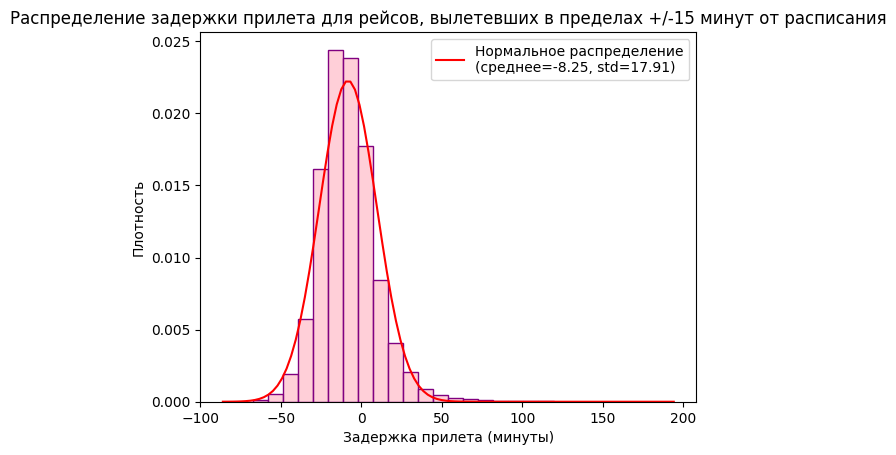

AndersonResult(statistic=1684.745487745182, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-8.251114540466393, scale=17.907214960280736)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [275]:
filtered_15 = raw_df[(raw_df['dep_delay'] >= -15) & (raw_df['dep_delay'] <= 15)]

plt.figure()
sns.histplot(filtered_15['arr_delay'], bins=30, kde=False, stat='density', color='pink', edgecolor='purple')


mean_delay = filtered_15['arr_delay'].mean()
std_delay = filtered_15['arr_delay'].std()

x = np.linspace(filtered_15['arr_delay'].min(), filtered_15['arr_delay'].max(), 100)
pdf = stats.norm.pdf(x, mean_delay, std_delay)

plt.plot(x, pdf, 'r', label=f'Нормальное распределение\n(среднее={mean_delay:.2f}, std={std_delay:.2f})')
plt.title('Распределение задержки прилета для рейсов, вылетевших в пределах +/-15 минут от расписания')
plt.xlabel('x, (Задержка прилета, мин)')
plt.ylabel('y, (Плотность)')
plt.legend()
plt.show()

print(stats.anderson(filtered_15['arr_delay'], 'norm'))



Тест Андерсона-Дарлинга говорит, что данные описываются нормальным распределением.